## Load Packages and Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

import os
from scipy.sparse import coo_matrix

## Data Loading and Preprocessing

In [ ]:
train_data = pd.read_csv('product_data_5k.tsv', sep='\t')
train_data.columns

Index(['Uniq Id', 'Crawl Timestamp', 'Dataset Origin', 'Product Id',
       'Product Barcode', 'Product Company Type Source',
       'Product Brand Source', 'Product Brand Normalised Source',
       'Product Name Source', 'Match Rank', 'Match Score', 'Match Type',
       'Retailer', 'Product Category', 'Product Brand', 'Product Name',
       'Product Price', 'Sku', 'Upc', 'Product Url', 'Market',
       'Product Description', 'Product Currency',
       'Product Available Inventory', 'Product Image Url',
       'Product Model Number', 'Product Tags', 'Product Contents',
       'Product Rating', 'Product Reviews Count', 'Bsr', 'Joining Key'],
      dtype='object')

In [5]:
train_data = train_data[['Uniq Id','Product Id', 'Product Rating', 'Product Reviews Count', 'Product Category', 'Product Brand', 'Product Name', 'Product Image Url', 'Product Description', 'Product Tags']]
train_data.head(1)

,Uniq Id,Product Id,Product Rating,Product Reviews Count,Product Category,Product Brand,Product Name,Product Image Url,Product Description,Product Tags
0,1705736792d82aa2f2d3caf1c07c53f4,2e17bf4acecdece67fc00f07ad62c910,NaN,NaN,Premium Beauty > Premium Makeup > Premium Nail...,OPI,"OPI Infinite Shine, Nail Lacquer Nail Polish, ...",https://i5.walmartimages.com/asr/0e1f4c51-c1a4...,NaN,"OPI Infinite Shine, Nail Lacquer Nail Polish, ..."


In [6]:
train_data['Product Tags']

,Product Tags
0,"OPI Infinite Shine, Nail Lacquer Nail Polish, ..."
1,"Nice 'n Easy Permanent Color, 111 Natural Medi..."
2,Clairol Nice 'N Easy Permanent Color 7/106A Na...
3,"Kokie Professional Matte Lipstick, Hot Berry, ..."
4,"Gillette TRAC II Plus Razor Blade Refills, Fit..."
...,...
4995,"Garden Mint Room Spray (Double Strength), 4 ou..."
4996,Garnier Nutrisse Nourishing Hair Color Creme (...
4997,"Nail File Electric Drill, 6 in 1 Professional ..."
4998,Creed Love In Black Hair And Body Wash 6.8oz/2...


In [7]:
train_data.shape

(5000, 10)

In [8]:
train_data.isnull().sum()

,0
Uniq Id,0
Product Id,0
Product Rating,2806
Product Reviews Count,1654
Product Category,10
Product Brand,13
Product Name,0
Product Image Url,0
Product Description,1127
Product Tags,0


In [11]:
train_data['Product Rating'] = train_data['Product Rating'].fillna(train_data['Product Rating'].mean())
train_data['Product Reviews Count'] = train_data['Product Reviews Count'].fillna(train_data['Product Reviews Count'].median())
train_data['Product Category'] = train_data['Product Category'].fillna("Unknown")
train_data['Product Brand'] = train_data['Product Brand'].fillna("Unknown")
train_data['Product Description'] = train_data['Product Description'].fillna("No Description")

In [12]:
train_data.isnull().sum()

,0
Uniq Id,0
Product Id,0
Product Rating,0
Product Reviews Count,0
Product Category,0
Product Brand,0
Product Name,0
Product Image Url,0
Product Description,0
Product Tags,0


In [13]:
train_data.duplicated().sum()

0

In [14]:
# make columns shorter
# Define the mapping of current column names to shorter names
column_name_mapping = {
    'Uniq Id': 'ID',
    'Product Id': 'ProdID',
    'Product Rating': 'Rating',
    'Product Reviews Count': 'ReviewCount',
    'Product Category': 'Category',
    'Product Brand': 'Brand',
    'Product Name': 'Name',
    'Product Image Url': 'ImageURL',
    'Product Description': 'Description',
    'Product Tags': 'Tags',
    'Product Contents': 'Contents'
}
# Rename the columns using the mapping
train_data.rename(columns=column_name_mapping, inplace=True)

In [15]:
train_data['ID'] = train_data['ID'].str.extract(r'(\d+)').astype(float)
train_data['ProdID'] = train_data['ProdID'].str.extract(r'(\d+)').astype(float)

In [16]:
train_data.head(1)

,ID,ProdID,Rating,ReviewCount,Category,Brand,Name,ImageURL,Description,Tags
0,1.705737e+09,2.0,4.294622,20.0,Premium Beauty > Premium Makeup > Premium Nail...,OPI,"OPI Infinite Shine, Nail Lacquer Nail Polish, ...",https://i5.walmartimages.com/asr/0e1f4c51-c1a4...,No Description,"OPI Infinite Shine, Nail Lacquer Nail Polish, ..."


## EDA (Exploratory Data Analysis)

In [17]:
# Basic statistics
num_users = train_data['ID'].nunique()
num_items = train_data['ProdID'].nunique()
num_ratings = train_data['Rating'].nunique()
print(f"Number of unique users: {num_users}")
print(f"Number of unique items: {num_items}")
print(f"Number of unique ratings: {num_ratings}")

Number of unique users: 1721
Number of unique items: 1697
Number of unique ratings: 36


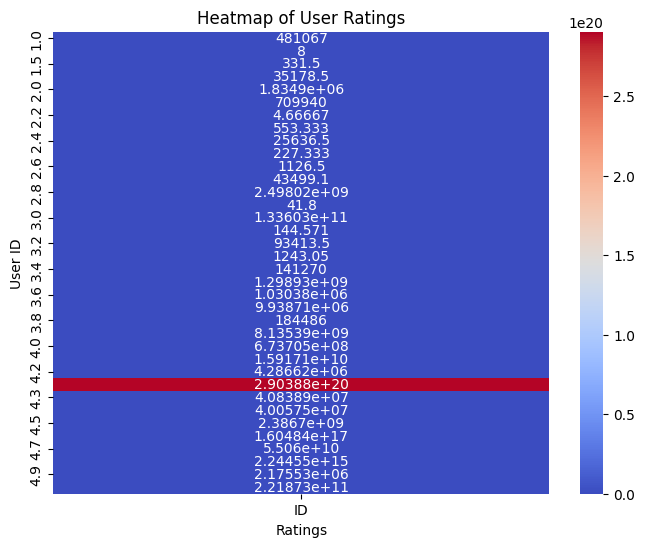

In [18]:
# Pivot the DataFrame to create a heatmap
heatmap_data = train_data.pivot_table('ID', 'Rating')

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt='g', cmap='coolwarm', cbar=True)
plt.title('Heatmap of User Ratings')
plt.xlabel('Ratings')
plt.ylabel('User ID')
plt.show()

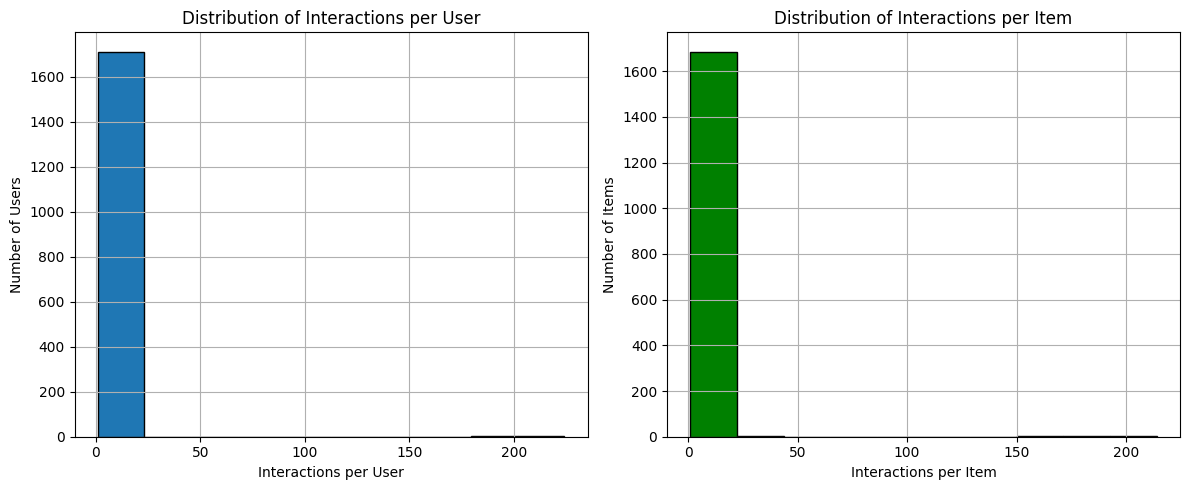

In [19]:
# Distribution of interactions
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
train_data['ID'].value_counts().hist(bins=10, edgecolor='k')
plt.xlabel('Interactions per User')
plt.ylabel('Number of Users')
plt.title('Distribution of Interactions per User')

plt.subplot(1, 2, 2)
train_data['ProdID'].value_counts().hist(bins=10, edgecolor='k',color='green')
plt.xlabel('Interactions per Item')
plt.ylabel('Number of Items')
plt.title('Distribution of Interactions per Item')

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Most Popular items')

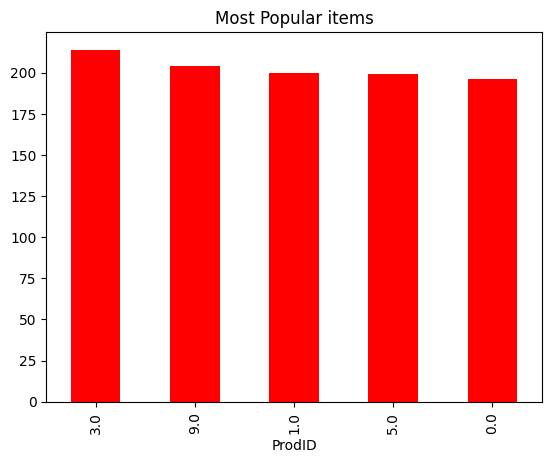

In [20]:
# Most popular items
popular_items = train_data['ProdID'].value_counts().head(5)
popular_items.plot(kind='bar',color='red')
plt.title("Most Popular items")

<Axes: xlabel='Rating'>

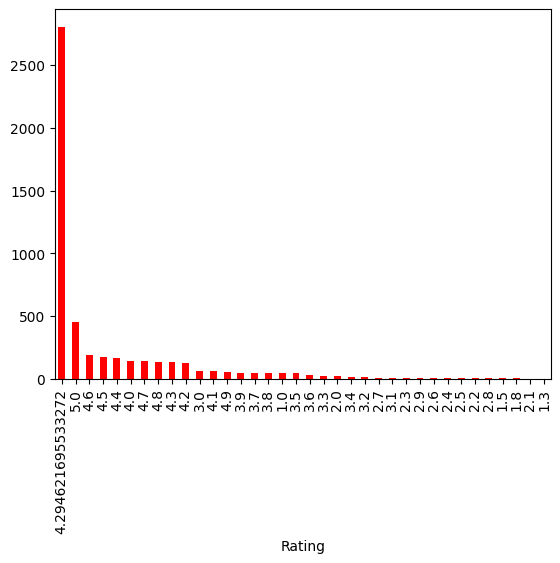

In [21]:
# most rated counts
train_data['Rating'].value_counts().plot(kind='bar',color='red')

## Data Cleaning and Tags Creations

In [22]:
import spacy # this a nlp lib used fot sentiment analysis,etc...
from spacy.lang.en.stop_words import STOP_WORDS

nlp = spacy.load("en_core_web_sm")

def clean_and_extract_tags(text):
    doc = nlp(text.lower())
    tags = [token.text for token in doc if token.text.isalnum() and token.text not in STOP_WORDS]
    return ', '.join(tags)

columns_to_extract_tags_from = ['Category', 'Brand', 'Description']

for column in columns_to_extract_tags_from:
    train_data[column] = train_data[column].apply(clean_and_extract_tags)

In [23]:
# Concatenate the cleaned tags from all relevant columns
train_data['Tags'] = train_data[columns_to_extract_tags_from].apply(lambda row: ', '.join(row), axis=1)

In [24]:
train_data.head(1)

,ID,ProdID,Rating,ReviewCount,Category,Brand,Name,ImageURL,Description,Tags
0,1.705737e+09,2.0,4.294622,20.0,"premium, beauty, premium, makeup, premium, nai...",opi,"OPI Infinite Shine, Nail Lacquer Nail Polish, ...",https://i5.walmartimages.com/asr/0e1f4c51-c1a4...,description,"premium, beauty, premium, makeup, premium, nai..."


## Rating Base Recommendations System

In [25]:
average_ratings = train_data.groupby(['Name','ReviewCount','Brand','ImageURL'])['Rating'].mean().reset_index()

In [26]:
top_rated_items = average_ratings.sort_values(by='Rating', ascending=False)

rating_base_recommendation = top_rated_items.head(10)

In [27]:
rating_base_recommendation['Rating'] = rating_base_recommendation['Rating'].astype(int)
rating_base_recommendation['ReviewCount'] = rating_base_recommendation['ReviewCount'].astype(int)

<ipython-input-27-14a31ed65ba8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_base_recommendation['Rating'] = rating_base_recommendation['Rating'].astype(int)
<ipython-input-27-14a31ed65ba8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_base_recommendation['ReviewCount'] = rating_base_recommendation['ReviewCount'].astype(int)


In [28]:
print("Rating Base Recommendation System: (Trending Products)")
rating_base_recommendation[['Name','Rating','ReviewCount','Brand','ImageURL']] = rating_base_recommendation[['Name','Rating','ReviewCount','Brand','ImageURL']]
rating_base_recommendation

Rating Base Recommendation System: (Trending Products)


<ipython-input-28-6e413a8a573d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_base_recommendation[['Name','Rating','ReviewCount','Brand','ImageURL']] = rating_base_recommendation[['Name','Rating','ReviewCount','Brand','ImageURL']]


,Name,ReviewCount,Brand,ImageURL,Rating
3319,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,1,opi,https://i5.walmartimages.com/asr/248196f4-66d1...,5
1337,ConvaTec ER Squibb & Sons ConvaTec Stomahesive...,1,convatec,https://i5.walmartimages.com/asr/5c6608c3-c150...,5
4616,"UNITE Hair Boosta Shampoo, 33Oz",5,unite,https://i5.walmartimages.com/asr/a214eefd-c157...,5
3858,Redken Flash Lift Maximum Power / Lightening P...,2,redken,https://i5.walmartimages.com/asr/65c63ea8-ba63...,5
4608,Twisted Curl Magnifier Styling Cream by Sebast...,5,"sebastian, professional",https://i5.walmartimages.com/asr/9232a734-df57...,5
462,"Acqua Di Gio Eau De Toilette Spray, Cologne fo...",4,"giorgio, armani",https://i5.walmartimages.com/asr/94d84d28-83c7...,5
925,"Brut Antiperspirant & Deodorant for Men, Origi...",1,brut,https://i5.walmartimages.com/asr/7f03fa0b-7c65...,5
1928,"Gaiam Kids Yoga Mat Pink Zebra, 4mm",13,gaiam,https://i5.walmartimages.com/asr/1e3a766f-4185...,5
1924,GUM 527 Technique Deep Clean Toothbrush -Ultra...,2,gum,https://i5.walmartimages.com/asr/918216fc-2ba7...,5
471,Advanced Clinicals Collagen Cream & Hyaluronic...,1,"advanced, clinicals",https://i5.walmartimages.com/asr/d5f55fb6-c58c...,5


## Content Base Recommendation system (User Preferences or Items similarities)

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix_content = tfidf_vectorizer.fit_transform(train_data['Tags'])
cosine_similarities_content = cosine_similarity(tfidf_matrix_content,tfidf_matrix_content)

In [30]:
cosine_similarities_content

array([[1.        , 0.00343603, 0.00359073, ..., 0.1338101 , 0.33305161,
        0.05624056],
       [0.00343603, 1.        , 0.38086046, ..., 0.02315363, 0.00181732,
        0.0381051 ],
       [0.00359073, 0.38086046, 1.        , ..., 0.03960089, 0.00189914,
        0.0591094 ],
       ...,
       [0.1338101 , 0.02315363, 0.03960089, ..., 1.        , 0.00121549,
        0.0379399 ],
       [0.33305161, 0.00181732, 0.00189914, ..., 0.00121549, 1.        ,
        0.00537967],
       [0.05624056, 0.0381051 , 0.0591094 , ..., 0.0379399 , 0.00537967,
        1.        ]])

In [31]:
item_name = 'OPI Infinite Shine, Nail Lacquer Nail Polish, Bubble Bath'
item_index = train_data[train_data['Name']==item_name].index[0]

In [32]:
similar_items = list(enumerate(cosine_similarities_content[item_index]))

In [34]:
similar_items = sorted(similar_items, key=lambda x:x[1], reverse=True)
top_similar_items = similar_items[1:10]

recommended_items_indics = [x[0] for x in top_similar_items]

In [35]:
train_data.iloc[recommended_items_indics][['Name','ReviewCount','Brand']]

,Name,ReviewCount,Brand
156,OPI Nail Lacquer Polish .5oz/15mL - This Gown ...,20.0,opi
184,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,20.0,opi
205,OPI Nail Lacquer - Dont Bossa Nova Me Around -...,20.0,opi
237,OPI Infinite Shine 2 Polish - ISL P33 - Alpaca...,5.0,opi
325,OPI Gel Polish Fall 2019 Scotland Collection G...,1.0,opi
375,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,1.0,opi
402,"OPI Nail Polish, Strawberry Margarita, 0.5 Fl Oz",57.0,opi
706,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,1.0,opi
886,OPI- Nail Lacquer-GelColor - &quotLiv&quotin t...,20.0,opi


## Function To Recommend Products for Content Base

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def content_based_recommendations(train_data, item_name, top_n=10):
    # Check if the item name exists in the training data
    if item_name not in train_data['Name'].values:
        print(f"Item '{item_name}' not found in the training data.")
        return pd.DataFrame()

    # Create a TF-IDF vectorizer for item descriptions
    tfidf_vectorizer = TfidfVectorizer(stop_words='english')

    # Apply TF-IDF vectorization to item descriptions
    tfidf_matrix_content = tfidf_vectorizer.fit_transform(train_data['Tags'])

    # Calculate cosine similarity between items based on descriptions
    cosine_similarities_content = cosine_similarity(tfidf_matrix_content, tfidf_matrix_content)

    # Find the index of the item
    item_index = train_data[train_data['Name'] == item_name].index[0]

    # Get the cosine similarity scores for the item
    similar_items = list(enumerate(cosine_similarities_content[item_index]))

    # Sort similar items by similarity score in descending order
    similar_items = sorted(similar_items, key=lambda x: x[1], reverse=True)

    # Get the top N most similar items (excluding the item itself)
    top_similar_items = similar_items[1:top_n+1]

    # Get the indices of the top similar items
    recommended_item_indices = [x[0] for x in top_similar_items]

    # Get the details of the top similar items
    recommended_items_details = train_data.iloc[recommended_item_indices][['Name', 'ReviewCount', 'Brand', 'ImageURL', 'Rating']]

    return recommended_items_details

In [37]:
# Example: Get content-based recommendations for a specific item
item_name = 'OPI Infinite Shine, Nail Lacquer Nail Polish, Bubble Bath'
content_based_rec = content_based_recommendations(train_data, item_name, top_n=8)

content_based_rec

,Name,ReviewCount,Brand,ImageURL,Rating
156,OPI Nail Lacquer Polish .5oz/15mL - This Gown ...,20.0,opi,https://i5.walmartimages.com/asr/71caed3f-5f83...,4.294622
184,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,20.0,opi,https://i5.walmartimages.com/asr/2d6f5147-53a8...,4.294622
205,OPI Nail Lacquer - Dont Bossa Nova Me Around -...,20.0,opi,https://i5.walmartimages.com/asr/fd1195d2-8d8d...,4.294622
237,OPI Infinite Shine 2 Polish - ISL P33 - Alpaca...,5.0,opi,https://i5.walmartimages.com/asr/7426eb5c-1690...,4.294622
325,OPI Gel Polish Fall 2019 Scotland Collection G...,1.0,opi,https://i5.walmartimages.com/asr/79bbbd9f-9a89...,4.294622
375,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,1.0,opi,https://i5.walmartimages.com/asr/744e869c-3500...,5.000000
402,"OPI Nail Polish, Strawberry Margarita, 0.5 Fl Oz",57.0,opi,https://i5.walmartimages.com/asr/b95676e5-96ab...,4.400000
706,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,1.0,opi,https://i5.walmartimages.com/asr/c7ba4815-52f7...,5.000000


In [38]:
# Example: Get content-based recommendations for a specific item
item_name = 'Kokie Professional Matte Lipstick, Hot Berry, 0.14 fl oz'
content_based_rec = content_based_recommendations(train_data, item_name, top_n=8)

content_based_rec

,Name,ReviewCount,Brand,ImageURL,Rating
3406,"Kokie Professional Matte Lipstick, Firecracker...",20.0,"kokie, cosmetics",https://i5.walmartimages.com/asr/8312221b-ed22...,4.294622
546,"Kokie Professional Matte Lipstick, Kiss Me, 0....",20.0,"kokie, cosmetics",https://i5.walmartimages.com/asr/27dd82a2-2b9c...,4.294622
2406,"L.A. Colors Matte Lipstick, Tender Matte",3.0,colors,https://i5.walmartimages.com/asr/271264fb-e8c3...,3.700000
4050,Kokie Professional Lip Poudre Liquid Matte Liq...,7.0,"kokie, cosmetics",https://i5.walmartimages.com/asr/fdd7498c-319f...,3.400000
4084,e.l.f. Mad for Matte 4 Piece Lip Color Set,20.0,cosmetics,https://i5.walmartimages.com/asr/e2d30304-edc9...,4.294622
1559,"LOreal Paris Colour Riche Matte Lip Liner, Mat...",495.0,paris,https://i5.walmartimages.com/asr/baf97085-7231...,4.400000
2873,Kokie Professional Lip Poudre Liquid Matte Liq...,7.0,"kokie, cosmetics",https://i5.walmartimages.com/asr/31c99d9b-ea11...,3.400000
3023,Be Matte Lipstick - Pink,2.0,"city, color",https://i5.walmartimages.com/asr/4425a13e-085f...,3.000000


## Collaborative Filtering (User Item Similarity)

In [39]:
user_item_matrix = train_data.pivot_table(index='ID', columns='ProdID', values='Rating',aggfunc='mean').fillna(0).astype(int)

In [40]:
user_similarity = cosine_similarity(user_item_matrix)

In [41]:
target_user_id = 4
target_user_index = user_item_matrix.index.get_loc(target_user_id)

In [42]:
user_similarities = user_similarity[target_user_index]

similar_user_indices = user_similarities.argsort()[::-1][1:]

In [43]:
recommend_items = []

for user_index in similar_user_indices:
    rated_by_similar_user = user_item_matrix.iloc[user_index]
    not_rated_by_target_user = (rated_by_similar_user==0) & (user_item_matrix.iloc[target_user_index]==0)

    recommend_items.extend(user_item_matrix.columns[not_rated_by_target_user][:10])

recommended_items_details = train_data[train_data['ProdID'].isin(recommend_items)][['Name','ReviewCount','Brand','ImageURL','Rating']]

In [44]:
recommended_items_details.head(10)

,Name,ReviewCount,Brand,ImageURL,Rating
31,Head & Shoulders Dandruff Conditioner Dry Scal...,20.0,"head, shoulders",https://i5.walmartimages.com/asr/a924d53f-007d...,4.294622
37,Wahl Color Pro Plus Haircut Kit 79752T,388.0,wahl,https://i5.walmartimages.com/asr/244aef35-aea3...,4.700000
40,"Pantene Pro-V Repairing Mask Treatment, Gold S...",176.0,pantene,https://i5.walmartimages.com/asr/fbd2ba15-5051...,4.100000
56,Grisi Soap - Avena Oat 3.5 Oz,20.0,grisi,https://i5.walmartimages.com/asr/aecd4fd9-bfec...,4.294622
58,"Humco Holding Group Glycerin, 16 Fl. Oz.",1.0,humco,https://i5.walmartimages.com/asr/52f2515b-09ca...,5.000000
86,LOreal Paris Feria Multi-Faceted Shimmering Pe...,2144.0,paris,https://i5.walmartimages.com/asr/c229026a-2b75...,3.100000
108,OPI Nail Dipping Powder Perfection Combo - Liq...,1.0,opi,https://i5.walmartimages.com/asr/ef1607ee-5bdb...,3.000000
128,"Navitas Organics, Organic, Goji Berries, 16 oz...",20.0,"navitas, organics",https://i5.walmartimages.com/asr/721ba73b-d4d5...,4.294622
144,Covidien Curity Maternity Pad Heavy 4.33&quot ...,20.0,covidien,https://i5.walmartimages.com/asr/e4e38217-ed43...,4.294622
147,Olay Complete Daily Moisturizer for Sensitive ...,737.0,olay,https://i5.walmartimages.com/asr/f8946948-5c8a...,4.700000


## Function That Recommend Items

In [45]:
def collaborative_filtering_recommendations(train_data, target_user_id, top_n=10):
    # Create the user-item matrix
    user_item_matrix = train_data.pivot_table(index='ID', columns='ProdID', values='Rating', aggfunc='mean').fillna(0)

    # Calculate the user similarity matrix using cosine similarity
    user_similarity = cosine_similarity(user_item_matrix)

    # Find the index of the target user in the matrix
    target_user_index = user_item_matrix.index.get_loc(target_user_id)

    # Get the similarity scores for the target user
    user_similarities = user_similarity[target_user_index]

    # Sort the users by similarity in descending order (excluding the target user)
    similar_users_indices = user_similarities.argsort()[::-1][1:]

    # Generate recommendations based on similar users
    recommended_items = []

    for user_index in similar_users_indices:
        # Get items rated by the similar user but not by the target user
        rated_by_similar_user = user_item_matrix.iloc[user_index]
        not_rated_by_target_user = (rated_by_similar_user == 0) & (user_item_matrix.iloc[target_user_index] == 0)

        # Extract the item IDs of recommended items
        recommended_items.extend(user_item_matrix.columns[not_rated_by_target_user][:top_n])

    # Get the details of recommended items
    recommended_items_details = train_data[train_data['ProdID'].isin(recommended_items)][['Name', 'ReviewCount', 'Brand', 'ImageURL', 'Rating']]

    return recommended_items_details.head(10)

# Example usage
target_user_id = 4
top_n = 5
collaborative_filtering_rec = collaborative_filtering_recommendations(train_data, target_user_id)
print(f"Top {top_n} recommendations for User {target_user_id}:")
collaborative_filtering_rec

Top 5 recommendations for User 4:


,Name,ReviewCount,Brand,ImageURL,Rating
31,Head & Shoulders Dandruff Conditioner Dry Scal...,20.0,"head, shoulders",https://i5.walmartimages.com/asr/a924d53f-007d...,4.294622
37,Wahl Color Pro Plus Haircut Kit 79752T,388.0,wahl,https://i5.walmartimages.com/asr/244aef35-aea3...,4.700000
40,"Pantene Pro-V Repairing Mask Treatment, Gold S...",176.0,pantene,https://i5.walmartimages.com/asr/fbd2ba15-5051...,4.100000
56,Grisi Soap - Avena Oat 3.5 Oz,20.0,grisi,https://i5.walmartimages.com/asr/aecd4fd9-bfec...,4.294622
58,"Humco Holding Group Glycerin, 16 Fl. Oz.",1.0,humco,https://i5.walmartimages.com/asr/52f2515b-09ca...,5.000000
86,LOreal Paris Feria Multi-Faceted Shimmering Pe...,2144.0,paris,https://i5.walmartimages.com/asr/c229026a-2b75...,3.100000
108,OPI Nail Dipping Powder Perfection Combo - Liq...,1.0,opi,https://i5.walmartimages.com/asr/ef1607ee-5bdb...,3.000000
128,"Navitas Organics, Organic, Goji Berries, 16 oz...",20.0,"navitas, organics",https://i5.walmartimages.com/asr/721ba73b-d4d5...,4.294622
144,Covidien Curity Maternity Pad Heavy 4.33&quot ...,20.0,covidien,https://i5.walmartimages.com/asr/e4e38217-ed43...,4.294622
147,Olay Complete Daily Moisturizer for Sensitive ...,737.0,olay,https://i5.walmartimages.com/asr/f8946948-5c8a...,4.700000


## Hybrid Recommendations

In [46]:
# Hybrid Recommendations (Combine Content-Based and Collaborative Filtering)
def hybrid_recommendations(train_data,target_user_id, item_name, top_n=10):
    # Get content-based recommendations
    content_based_rec = content_based_recommendations(train_data,item_name, top_n)

    # Get collaborative filtering recommendations
    collaborative_filtering_rec = collaborative_filtering_recommendations(train_data,target_user_id, top_n)

    # Merge and deduplicate the recommendations
    hybrid_rec = pd.concat([content_based_rec, collaborative_filtering_rec]).drop_duplicates()

    return hybrid_rec.head(10)

In [47]:
# Example usage: Get hybrid recommendations for a specific user and item
target_user_id = 4 # Change this to the user_id you want recommendations for
item_name = "OPI Nail Lacquer Polish .5oz/15mL - This Gown Needs A Crown NL U11"  # Change this to the item name
hybrid_rec = hybrid_recommendations(train_data,target_user_id, item_name, top_n=10)

print(f"Top 10 Hybrid Recommendations for User {target_user_id} and Item '{item_name}':")
hybrid_rec

Top 10 Hybrid Recommendations for User 4 and Item 'OPI Nail Lacquer Polish .5oz/15mL - This Gown Needs A Crown NL U11':


,Name,ReviewCount,Brand,ImageURL,Rating
156,OPI Nail Lacquer Polish .5oz/15mL - This Gown ...,20.0,opi,https://i5.walmartimages.com/asr/71caed3f-5f83...,4.294622
184,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,20.0,opi,https://i5.walmartimages.com/asr/2d6f5147-53a8...,4.294622
205,OPI Nail Lacquer - Dont Bossa Nova Me Around -...,20.0,opi,https://i5.walmartimages.com/asr/fd1195d2-8d8d...,4.294622
237,OPI Infinite Shine 2 Polish - ISL P33 - Alpaca...,5.0,opi,https://i5.walmartimages.com/asr/7426eb5c-1690...,4.294622
325,OPI Gel Polish Fall 2019 Scotland Collection G...,1.0,opi,https://i5.walmartimages.com/asr/79bbbd9f-9a89...,4.294622
375,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,1.0,opi,https://i5.walmartimages.com/asr/744e869c-3500...,5.000000
402,"OPI Nail Polish, Strawberry Margarita, 0.5 Fl Oz",57.0,opi,https://i5.walmartimages.com/asr/b95676e5-96ab...,4.400000
706,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,1.0,opi,https://i5.walmartimages.com/asr/c7ba4815-52f7...,5.000000
886,OPI- Nail Lacquer-GelColor - &quotLiv&quotin t...,20.0,opi,https://i5.walmartimages.com/asr/98b4194c-e026...,4.294622
1042,"OPI GelColor Gel Nail Polish, Dulce De Leche, ...",1.0,opi,https://i5.walmartimages.com/asr/c1b2c370-b2d2...,4.294622


In [48]:
# Example usage: Get hybrid recommendations for a specific user and item
target_user_id = 10 # Change this to the user_id you want recommendations for
item_name = 'Black Radiance Perfect Tone Matte Lip Crème, Succulent Plum'

hybrid_rec = hybrid_recommendations(train_data,target_user_id, item_name, top_n=10)

print(f"Top 10 Hybrid Recommendations for User {target_user_id} and Item '{item_name}':")
hybrid_rec

Top 10 Hybrid Recommendations for User 10 and Item 'Black Radiance Perfect Tone Matte Lip Crème, Succulent Plum':


,Name,ReviewCount,Brand,ImageURL,Rating
896,"Black Radiance Perfect Tone Lip Color, Vintage...",78.0,"black, radiance",https://i5.walmartimages.com/asr/485f26b4-a19a...,4.700000
2496,"Black Radiance Perfect Tone Lip Color, Hollywo...",18.0,"black, radiance",https://i5.walmartimages.com/asr/fe3da48f-5142...,4.300000
3,"Kokie Professional Matte Lipstick, Hot Berry, ...",20.0,"kokie, cosmetics",https://i5.walmartimages.com/asr/25b4b467-bc61...,4.294622
3406,"Kokie Professional Matte Lipstick, Firecracker...",20.0,"kokie, cosmetics",https://i5.walmartimages.com/asr/8312221b-ed22...,4.294622
2406,"L.A. Colors Matte Lipstick, Tender Matte",3.0,colors,https://i5.walmartimages.com/asr/271264fb-e8c3...,3.700000
4050,Kokie Professional Lip Poudre Liquid Matte Liq...,7.0,"kokie, cosmetics",https://i5.walmartimages.com/asr/fdd7498c-319f...,3.400000
2873,Kokie Professional Lip Poudre Liquid Matte Liq...,7.0,"kokie, cosmetics",https://i5.walmartimages.com/asr/31c99d9b-ea11...,3.400000
4872,"L.A. Colors Matte Lipstick, Torrid Matte",8.0,colors,https://i5.walmartimages.com/asr/62d6d9fa-eee1...,4.800000
1300,"e.l.f. Liquid Matte Lipstick, Tea Rose",476.0,cosmetics,https://i5.walmartimages.com/asr/58220de4-3875...,4.100000
420,Black Opal Color Splurge Sassy Luxe Matte Lips...,20.0,"black, opal",https://i5.walmartimages.com/asr/a991241b-e4ad...,4.294622
